In [1]:
import ROOT as rt
import uproot
import numpy as np
from collections import OrderedDict
import os
import sys
sys.path.append(os.getcwd().replace('scripts', 'lib'))

import tdrstyle
a = tdrstyle.setTDRStyle()

print(sys.version)

Welcome to JupyROOT 6.28/00
3.9.12 (main, Jun  7 2022, 16:09:12) 
[GCC 11.2.0]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()

prod =['ggH']
decay = 'bbbb'



mass = [40]

OLD_CTAU = np.array([1000, 10000, 100000])#in mm



path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/data/'

fpath['data'] = path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'


path = '/eos/uscms/store/user/cmsdas/2024/long_exercises/MDS/signal/nocuts/'

for m in mass:
    for ct in OLD_CTAU:
        key = 'MC_'+str(m)+'_'+str(ct)                       
        fpath[key] = path +  'ggH_HToSSTobbbb_MH-125_MS-40_ctau-'+str(ct)+'_137000pb_weighted.root'

NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']


# Ex0 - Basic Selections and Load Branches

In [4]:
%%time

deltaPhi = {}
Nhits = {}
weight = {}
cscRechitClusterJetVeto = {}
cscRechitClusterMuonVeto = {}
cscRechitClusterTimeSpread = {}
cscRechitClusterTime = {}
cscRechitClusterEta = {}
cscRechitClusterMe11 = {}
cscRechitClusterMe12 = {}

for k, T in tree.items():
    
    ########### SELECTION: CLUSTERS ############
    if 'data' in k:sel_clusters = T['cscRechitClusterSize'].array() > 0
    else: sel_clusters = np.logical_and(T['cscRechitCluster_match_gLLP'].array(), T['cscRechitCluster_match_gLLP_csc'].array())

    ########### SELECTION: JETS ############

    sel_jet = np.logical_and(T['jetPt'].array() > 30, np.abs(T['jetEta'].array()) < 2.4 )
    sel_jet = np.logical_and(sel_jet, T['jetTightPassId'].array())

    ########### SELECTION: EVENTS ############
    # select only triggered events
    sel_ev = T['METTrigger'].array()

    sel_ev  = np.logical_and(sel_ev,np.sum(sel_clusters, axis = 1)>0)
    sel_ev = np.logical_and(sel_ev ,T['met'].array() > 200)
    sel_ev = np.logical_and(sel_ev,T['metFilters'].array())
    sel_ev = np.logical_and(sel_ev , np.sum(sel_jet,axis=1)>=1)

    #### Save variables needed ####                                   

    deltaPhi[k] = T['cscRechitClusterMet_dPhi'].array()[sel_clusters][sel_ev][:,0]
    Nhits[k] = T['cscRechitClusterSize'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterJetVeto[k] = T['cscRechitClusterJetVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMuonVeto[k] = T['cscRechitClusterMuonVetoPt'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterTime[k] = T['cscRechitClusterTime'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterEta[k] = T['cscRechitClusterEta'].array()[sel_clusters][sel_ev][:,0]
    cscRechitClusterMe11[k] = (T['cscRechitClusterNRechitChamberPlus11'].array() + T['cscRechitClusterNRechitChamberMinus11'].array())[sel_clusters][sel_ev][:,0]
    cscRechitClusterMe12[k] = (T['cscRechitClusterNRechitChamberPlus12'].array() + T['cscRechitClusterNRechitChamberMinus12'].array())[sel_clusters][sel_ev][:,0]

    weight[k] = T['weight'].array()[sel_ev]
    print(k, np.sum(weight[k]))

data 906128.0
MC_40_1000 8391.234
MC_40_10000 5881.3994
MC_40_100000 804.09265


In [7]:
std_color_list = [1,2,4,6,8] #choose your favorite color in ROOT

# Ex1 - plot jet veto and muon veto

## plot jet veto

data 0.28715479490756274
MC_40_1000 0.8002997809293209
MC_40_10000 0.866107436683336
MC_40_100000 0.8695652173913043


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


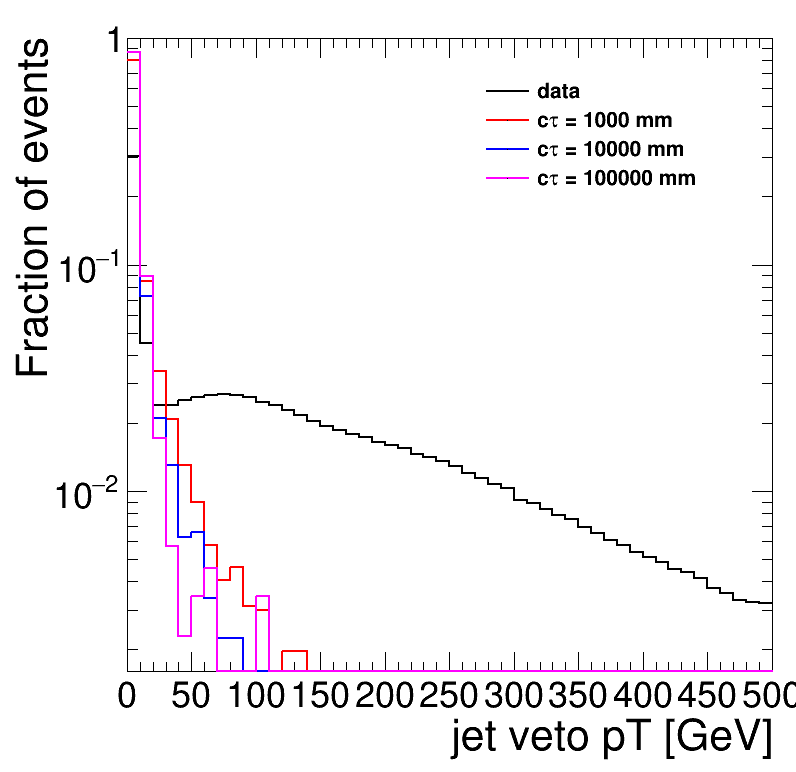

In [8]:
leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('jet veto pT [GeV]')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterJetVeto[k])): h[k].Fill(cscRechitClusterJetVeto[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterJetVeto[k]<10)/len(cscRechitClusterJetVeto[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

## plot muon veto

data 0.5921238500520898
MC_40_1000 0.9334716937622507
MC_40_10000 0.9391837393127924
MC_40_100000 0.9427917620137299


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


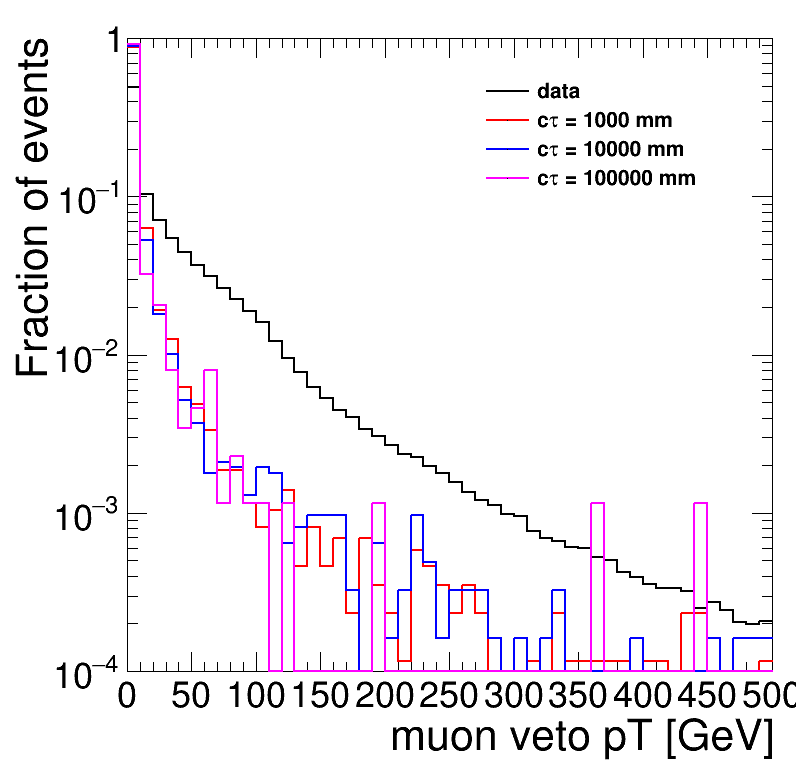

In [9]:
leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('muon veto pT [GeV]')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMuonVeto[k])): h[k].Fill(cscRechitClusterMuonVeto[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMuonVeto[k]<20)/len(cscRechitClusterMuonVeto[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex2 - plot number of ME11 and ME12 hits in the cluster

## plot number of ME11 hits in cluster

data 0.17571137852488833
MC_40_1000 0.7802375187363081
MC_40_10000 0.8522342313276335
MC_40_100000 0.8546910755148741
CPU times: user 1min 2s, sys: 196 ms, total: 1min 2s
Wall time: 1min 2s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


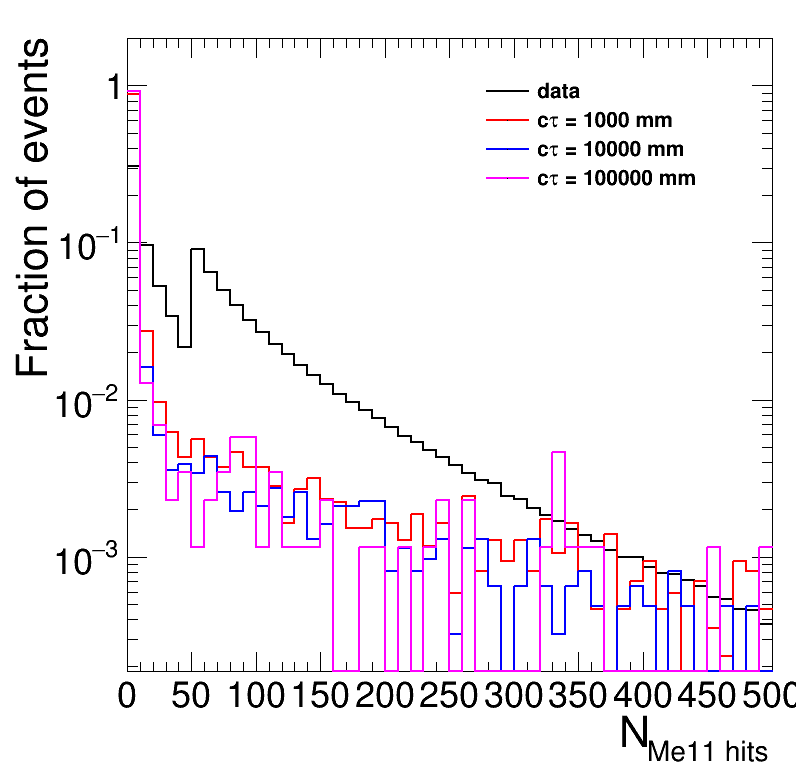

In [10]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('N_{Me11 hits}')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMe11[k])): h[k].Fill(cscRechitClusterMe11[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMe11[k]==0)/len(cscRechitClusterMe11[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

## plot number of ME12 hits in cluster

data 0.7526387000512069
MC_40_1000 0.6064798800876283
MC_40_10000 0.6594612034199064
MC_40_100000 0.665903890160183
CPU times: user 1min 2s, sys: 189 ms, total: 1min 2s
Wall time: 1min 2s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


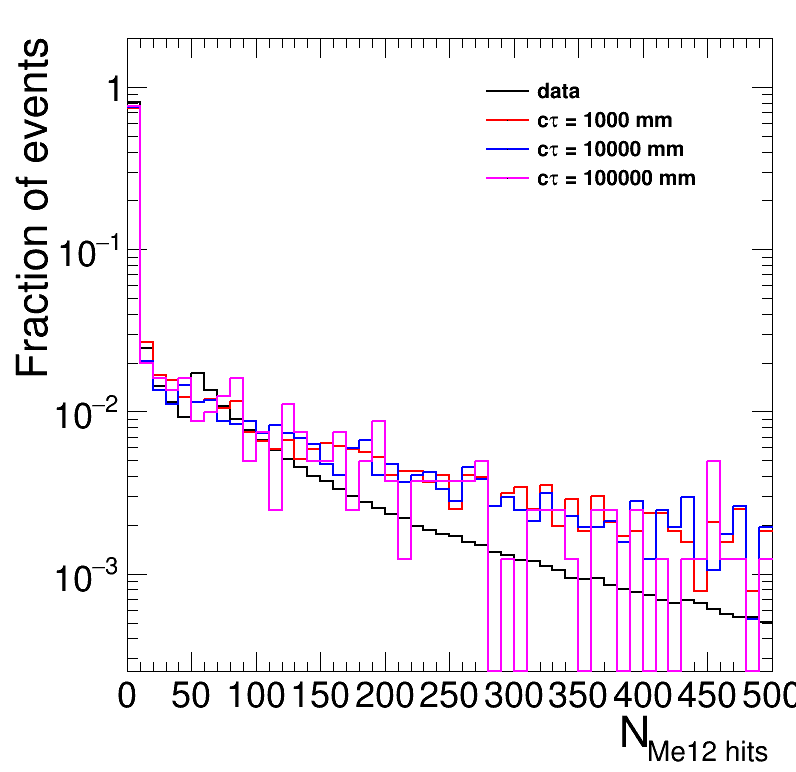

In [11]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0, 500)
    h[k].SetXTitle('N_{Me12 hits}')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterMe12[k])): h[k].Fill(cscRechitClusterMe12[k][j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(cscRechitClusterMe12[k]==0)/len(cscRechitClusterMe12[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex3 - plot cluster eta

data 0.5188218441544682
MC_40_1000 0.8732849071832123
MC_40_10000 0.9122439103081142
MC_40_100000 0.9210526315789473
CPU times: user 1min 2s, sys: 207 ms, total: 1min 2s
Wall time: 1min 2s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


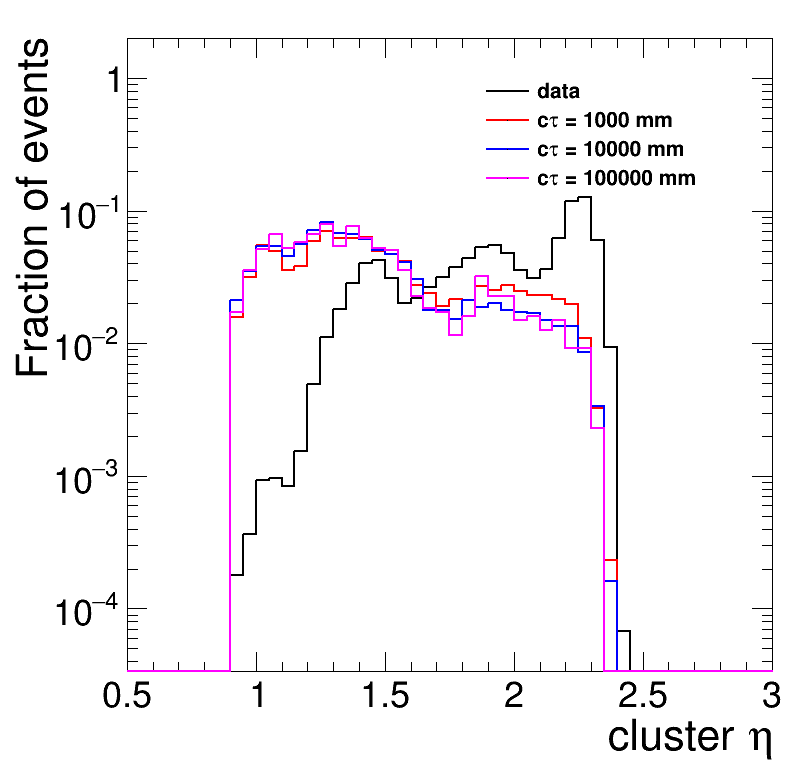

In [12]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 0.5, 3)
    h[k].SetXTitle('cluster #eta')
    h[k].SetYTitle('Fraction of events')
    for j in range(len(cscRechitClusterEta[k])): h[k].Fill(abs(cscRechitClusterEta[k][j]))

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.abs(cscRechitClusterEta[k])<2)/len(cscRechitClusterEta[k]))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(2)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')
leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

# Ex4 - plot cluster time (after vetos are applied)

data 0.29137863204631037
MC_40_1000 0.9998219373219374
MC_40_10000 0.9689333043667173
MC_40_100000 0.9192073170731707
CPU times: user 5.53 s, sys: 27.8 ms, total: 5.56 s
Wall time: 5.55 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


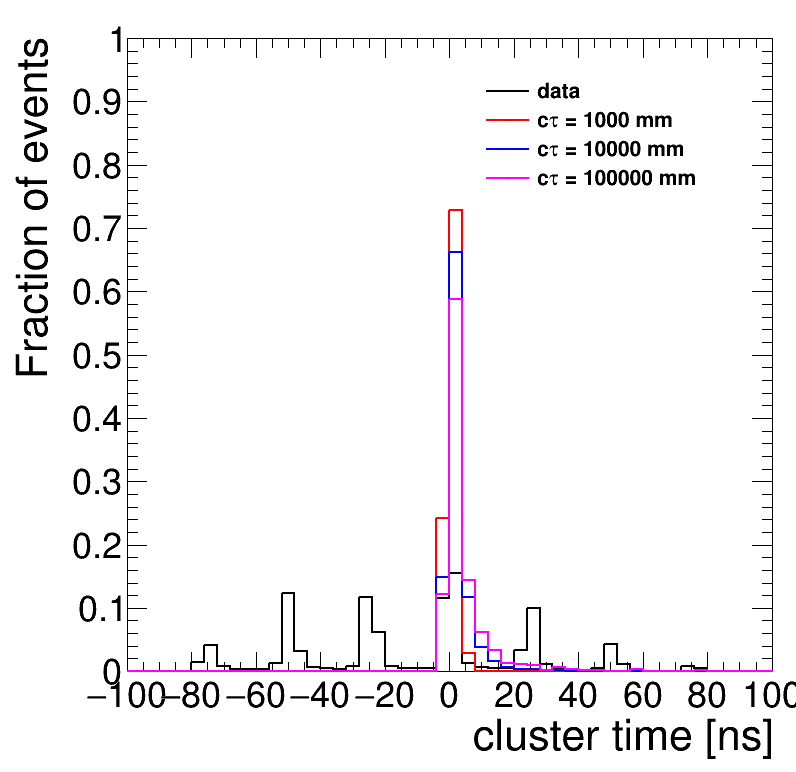

In [22]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, -100, 100)
    h[k].SetXTitle('cluster time [ns]')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    
    time_temp = cscRechitClusterTime[k][sel]
    for j in range(len(time_temp)): h[k].Fill(time_temp[j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.logical_and(time_temp<12.5, time_temp>-5))/len(time_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetRightMargin(0.03)
c.Draw()

# Ex5 - plot $\Delta\phi\mathrm{(cluster, MET)}$ and $N_{hits}$ in Out-of-time Validation Region (final discriminating variables)

## plot $N_{hits}$

data 0.051152936841782064
MC_40_1000 0.8823005698005698
MC_40_10000 0.8138170758201173
MC_40_100000 0.7820121951219512
CPU times: user 2.94 s, sys: 11.9 ms, total: 2.95 s
Wall time: 2.95 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


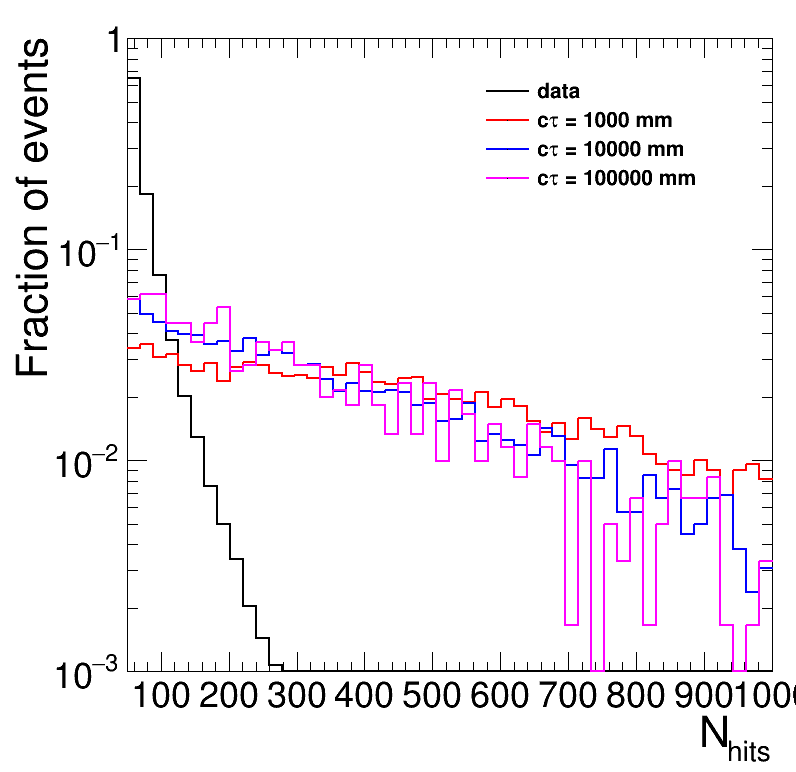

In [21]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
    
    h[k] = rt.TH1D('', '', 50, 50, 1000)
    h[k].SetXTitle('N_{hits}')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    if 'data' in k: sel = np.logical_and(sel, cscRechitClusterTime[k]<-12.5)
    nhits_temp = Nhits[k][sel]
    for j in range(len(nhits_temp)): h[k].Fill(nhits_temp[j])
        
    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(nhits_temp>130)/len(nhits_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(1)
    h[k].SetMinimum(1e-3)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetLogy()
c.SetRightMargin(0.03)
c.Draw()

## plot $\Delta\phi\mathrm{(cluster, MET)}$

data 0.2332586201602751
MC_40_1000 0.9902065527065527
MC_40_10000 0.9463393439061482
MC_40_100000 0.9359756097560976
CPU times: user 2.97 s, sys: 16.3 ms, total: 2.98 s
Wall time: 2.98 s


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


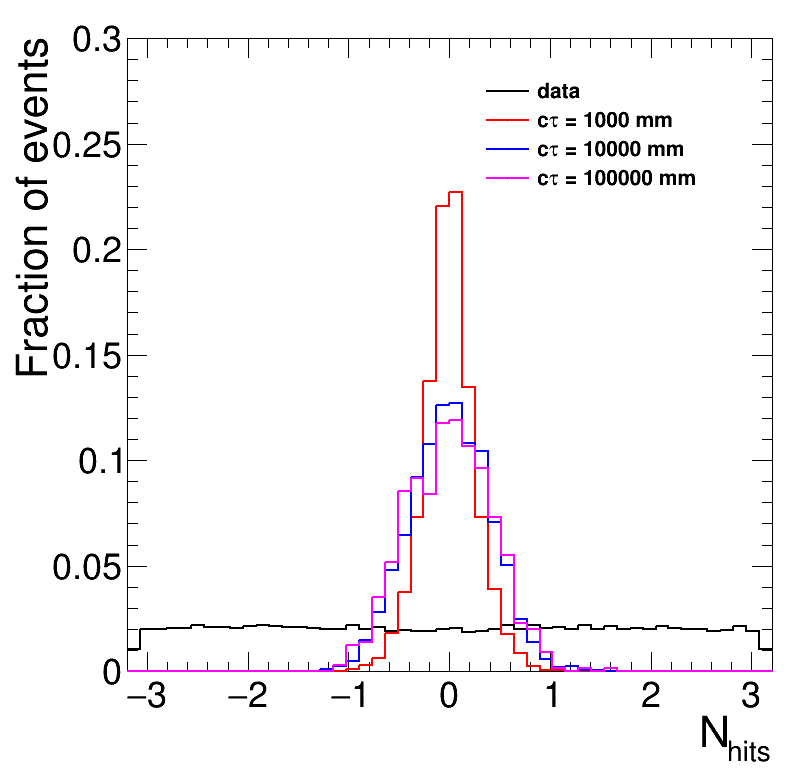

In [24]:
%%time

leg = rt.TLegend(0.6,0.75,0.90,0.90)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
rt.gStyle.SetOptFit(1011)
h = {}
for i, k in enumerate(tree.keys()):
   
        
    h[k] = rt.TH1D('', '', 50, -3.2,3.2)
    h[k].SetXTitle('N_{hits}')
    h[k].SetYTitle('Fraction of events')
    
    sel = np.logical_and(cscRechitClusterJetVeto[k]<10, cscRechitClusterMuonVeto[k]<20)
    sel = np.logical_and(sel, np.abs(cscRechitClusterEta[k])<2)
    if 'data' in k: sel = np.logical_and(sel, cscRechitClusterTime[k]<-12.5)
    dphi_temp = deltaPhi[k][sel]
    for j in range(len(dphi_temp)): h[k].Fill(dphi_temp[j])

    # calculate the efficiency of the cuts  
    print(k, np.count_nonzero(np.abs(dphi_temp)<0.75)/len(dphi_temp))
    
    h[k].SetLineColor(std_color_list[i])
    h[k].Scale(1./h[k].Integral())
    h[k].SetMaximum(0.3)
    if k == 'data':leg.AddEntry(h[k],k)
    else: leg.AddEntry(h[k],'c#tau = {} mm'.format(k.split('_')[-1]))
    h[k].Draw('hist same')

leg.Draw()
c.SetRightMargin(0.03)
c.Draw()